In [44]:
import tensorflow as tf
import numpy as np

In [60]:
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import cv2

model = load_model("C:\\Workspaces\\mini3\\model.h5",custom_objects={'BatchNormalization': BatchNormalization, 'Dropout' : Dropout})

In [61]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,840,873 (18.47 MB)

 Trainable params: 4,797,312 (18.30 MB)

 Non-trainable params: 43,559 (170.16 KB)

 Optimizer params: 2 (12.00 B)

In [62]:
from sklearn.utils import shuffle
from tensorflow.keras.utils import Sequence

class FurnitureSequence(Sequence):
  def __init__(self, images, labels, batch_size=32, image_size=224, augmentor=None, preprocess_function=None, shuffle=True):
    self.images = images
    self.labels = labels
    self.batch_size = batch_size
    self.image_size = image_size
    self.augmentor = augmentor
    self.preprocess_function = preprocess_function
    self.shuffle = shuffle
    self.indexes = np.arange(len(images))
    if self.shuffle:
      np.random.shuffle(self.indexes)

  def __len__(self):
    return int(np.ceil(len(self.images) / self.batch_size)) # 배치 사이즈만큼 돌리기

  def __getitem__(self, index): #index번재 배치 데이터 반환
    start = index * self.batch_size
    end = (index + 1) * self.batch_size
    this_batch_images = self.images[start:end]
    batch_labels = self.labels[start:end] if self.labels is not None else None # 예측에는 라벨 필요없음

    # 배치 크기에 맞는 배열 초기화 (리사이즈된 결과를 저장할 새로운 배열 필요)
    batch_images = np.zeros((this_batch_images.shape[0], self.image_size, self.image_size, 3), dtype=np.float32)

    for i, image_path in enumerate(this_batch_images):
      image = cv2.imread(image_path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

      # 데이터 증강 적용
      if self.augmentor is not None:
        image = self.augmentor(image=image)['image'] # augment 딕셔너리 반환해서, 필요한 데이터(이미지만 추출)만 명시적으로 추출, 데이터 증강 도구는 이미지 외의 데이터를 함께 처리할 수 있어서('mask','bboxes' 등)

      # 리사이즈
      image = cv2.resize(image,(self.image_size, self.image_size))

      # 정규화
      image = image.astype('float32')/255.0

      # 전처리
      if self.preprocess_function is not None:
        image = self.preprocess_function(image)

      batch_images[i] = image

    return (batch_images, np.zeros((this_batch_images.shape[0],), dtype=np.float32))

  def on_epoch_end(self): # 에포크 종료 후 데이터 섞기.
    if self.shuffle:
      self.images, self.labels = shuffle(self.images, self.labels)



In [63]:
furniture_path = np.array([
  "C:\\Users\\playdata2\\Desktop\\sample\\dt.jpg",
  "C:\\Users\\playdata2\\Desktop\\sample\\sf1.jpg",
  "C:\\Users\\playdata2\\Desktop\\sample\\sf2.jpg",
  "C:\\Users\\playdata2\\Desktop\\sample\\cha.jpg",
  "C:\\Users\\playdata2\\Desktop\\sample\\cab.jpg",
])


In [64]:
furniture_path

array(['C:\\Users\\playdata2\\Desktop\\sample\\dt.jpg',
       'C:\\Users\\playdata2\\Desktop\\sample\\sf1.jpg',
       'C:\\Users\\playdata2\\Desktop\\sample\\sf2.jpg',
       'C:\\Users\\playdata2\\Desktop\\sample\\cha.jpg',
       'C:\\Users\\playdata2\\Desktop\\sample\\cab.jpg'], dtype='<U41')

In [67]:
import matplotlib.pyplot as plt

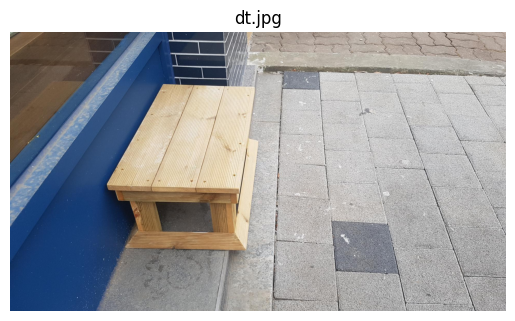

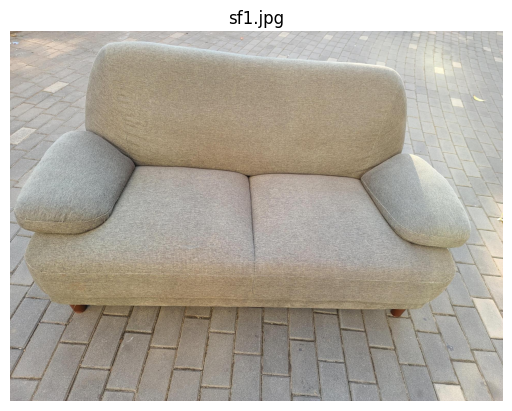

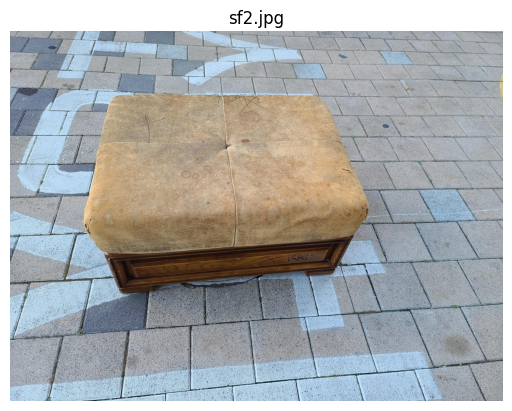

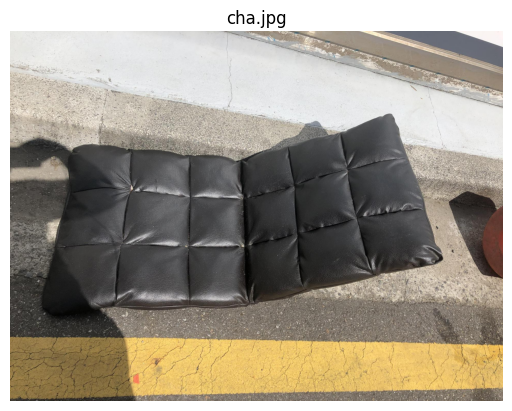

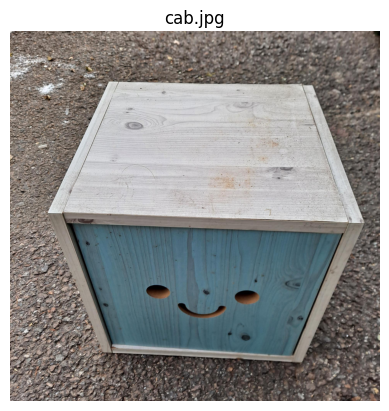

In [68]:

# 이미지 표시
for path in furniture_path:
    # 이미지 로드 (OpenCV는 기본적으로 BGR 형식으로 로드됨)
    image = cv2.imread(path)
    if image is None:
        print(f"Failed to load image: {path}")
        continue
    
    # BGR -> RGB로 변환 (Matplotlib는 RGB 형식 사용)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # 시각화
    plt.imshow(image)
    plt.title(path.split("\\")[-1])  # 이미지 파일명만 타이틀로 표시
    plt.axis('off')  # 축 숨기기
    plt.show()

In [65]:
test2_seq = FurnitureSequence(
  furniture_path,
  None,
  batch_size=len(furniture_path),
  image_size=224,
  preprocess_function=preprocess_input,
  shuffle=False
)

pred_proba = model.predict(test2_seq)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [66]:
print(pred_proba)
print(np.argmax(pred_proba, axis=1))
pred_classes = [class_names[idx] for idx in np.argmax(pred_proba, axis=1).squeeze()]

[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]
[3 3 3 3 3]


In [53]:
pred_proba

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [54]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,840,873 (18.47 MB)

 Trainable params: 4,797,312 (18.30 MB)

 Non-trainable params: 43,559 (170.16 KB)

 Optimizer params: 2 (12.00 B)

In [ ]:
model.export("saved_model_directory")
model.export("model.keras")

INFO:tensorflow:Assets written to: saved_model_directory\assets


INFO:tensorflow:Assets written to: saved_model_directory\assets


Saved artifact at 'saved_model_directory'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  2530653194192: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  2530653193840: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  2530657017648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2530657016240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2530657018352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2530657011840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2530657015008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2530657021520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2530657020112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2530657022048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  253065701852

In [28]:
import tensorflow as tf
from tensorflow import keras

# SavedModel 디렉토리 경로
saved_model_path = "saved_model_directory"

# TFSMLayer로 모델 로드
loaded_layer = keras.layers.TFSMLayer(saved_model_path, call_endpoint='serving_default')

# 새로운 모델에 로드된 레이어 추가
model = keras.Sequential([
    loaded_layer,
    # 필요한 추가 레이어들...
])

# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')


In [29]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tfsm_layer (TFSMLayer)          │ ?                      │     4,840,864 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,840,864 (18.47 MB)

 Trainable params: 4,797,312 (18.30 MB)

 Non-trainable params: 43,552 (170.12 KB)

In [32]:
image_np = np.array(image)
IMAGE_SIZE = 224

# cv2 대신 tf.image.resize 사용
resized_image = tf.image.resize(image_np, (IMAGE_SIZE, IMAGE_SIZE))
print('resized_image', type(resized_image), resized_image.shape) # <class 'tensorflow.python.framework.ops.EagerTensor'>  (224, 224, 3)
# EagerTensor 타입을 NumPy 배열로 다시 변환
a_image = resized_image.numpy().astype(np.float32)
# EfficientNetB0용 스케일링
a_image = preprocess_input(a_image)
batch_image = a_image.reshape(1, IMAGE_SIZE, IMAGE_SIZE, 3)
pred_proba = model.predict(batch_image)

resized_image <class 'tensorflow.python.framework.ops.EagerTensor'> (224, 224, 3)


ValueError: Sequential model 'sequential' has already been configured to use input shape (32, 1921, 3). You cannot build it with input_shape (1, 224, 224, 3)

In [33]:
pred_proba

array([[0., 0., 0., 1.]], dtype=float32)

In [44]:
class_names = ['cabinet', 'chair', 'dining_table', 'sofa']
pred = np.argmax(pred_proba)
pred_label = class_names[pred]
pred_proba

array([[0., 0., 0., 1.]], dtype=float32)